In [1]:
from IPython import get_ipython
from IPython.display import display

%matplotlib inline

import gym
import matplotlib.pyplot as plt
import numpy as np
import sys

from collections import defaultdict

plt.style.use('ggplot')

In [2]:
# make the black jack environment
env = gym.make('Blackjack-v1')

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Monte Carlo Prediction for Estimating Value Function

we create a `mc_predictions()` function which implements the **Monte Carlo prediction algorithm** for estimating the value function of a given policy. It does so by simulating episodes in an environment and averaging the returns observed from each state.

### Arguments:
- **policy**: A function that takes the current state and returns an action.
- **env**: The OpenAI Gym environment (such as Blackjack).
- **num_episodes**: The number of episodes (interactions with the environment) to simulate.
- **discount_factor**: A discount factor (`gamma`) to discount future rewards.


In [9]:
def mc_predictions(policy, env, num_episodes, discount_factor=1.0):
  """
   Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.

    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.

    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """
  #Gives total reward for each state
  return_sum = defaultdict(float)
  return_count = defaultdict(float) # how many times state has beed encountered

  # final value function
  V = defaultdict(float)

  for i_eposide in range(1, num_episodes + 1):
    if i_eposide % 1000 == 0:
      print("\rEpisode {}/{}.".format(i_eposide, num_episodes), end="")
      sys.stdout.flush()

    # generate eposide(array of state, action, reward) tuples
    episode = []
    state = env.reset()
    for t in range(100):
      action = policy(state)
      next_state, reward, done, _ = env.step(action)
      episode.append((state, action, reward))
      if done:
        break
      state = next_state
    # Find all states the we've visited in this episode
    # We convert each state to a tuple so that we can use it as a dict key
    states_in_eposides = set([tuple(x[0]) if isinstance(x[0], list) else x[0] for x in episode])

    for state in states_in_eposides:
      first_occurance_idx = next(i for i, x in enumerate(episode) if x[0] == state)
      G = sum([x[2] * (discount_factor ** i) for i, x in enumerate(episode[first_occurance_idx:])])

      return_sum[state] += G
      return_count[state] += 1.0
      V[state] = return_sum[state] / return_count[state]

  return V

## `sample_policy()` Function

The `sample_policy()` function defines a simple policy for playing Blackjack. The policy determines whether the agent should **stick** (stop drawing cards) or **hit** (draw another card) based on the player's current score.


### Policy:
- If the player's score is **20 or higher**, the agent **sticks** (does not take any more cards).
- If the player's score is **less than 20**, the agent **hits** (draws another card).

### Return:
- **`0`**: Represents **stick**.
- **`1`**: Represents **hit**.

### Example:
For the input `observation = (18, 7, False)`:
- The player's score is 18, so the agent will hit, returning `1`.

For the input `observation = (21, 7, True)`:
- The player's score is 21, so the agent will stick, returning `0`.

### Purpose:
This policy is simple and follows basic Blackjack strategy by sticking when the score is strong (20 or greater) and hitting when the score is lower.


In [10]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

## Visualizing the Value Function

The function helps visualize how the value function changes with different states in Blackjack. The 3D surface plots allow you to observe how the agent values different states depending on the player's sum, dealer's showing card, and whether the player has a usable ace.


In [21]:

import gym
from IPython import display
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
%matplotlib inline

EpisodeStats = namedtuple('Stats', ['episode_lengths', 'episode_rewards'])


def plot_value_function(V, title = "Value Function"):
    '''
    Plots the value function as a surface plot.
    '''
    min_x = 11 # min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize = (20, 10))
        ax = fig.add_subplot(111, projection = '3d')
        surf = ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1,
                               cmap = matplotlib.cm.coolwarm, vmin = -1.0, vmax = 1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



## Running Monte Carlo Prediction and Visualizing the Value Function

Episode 10000/10000.

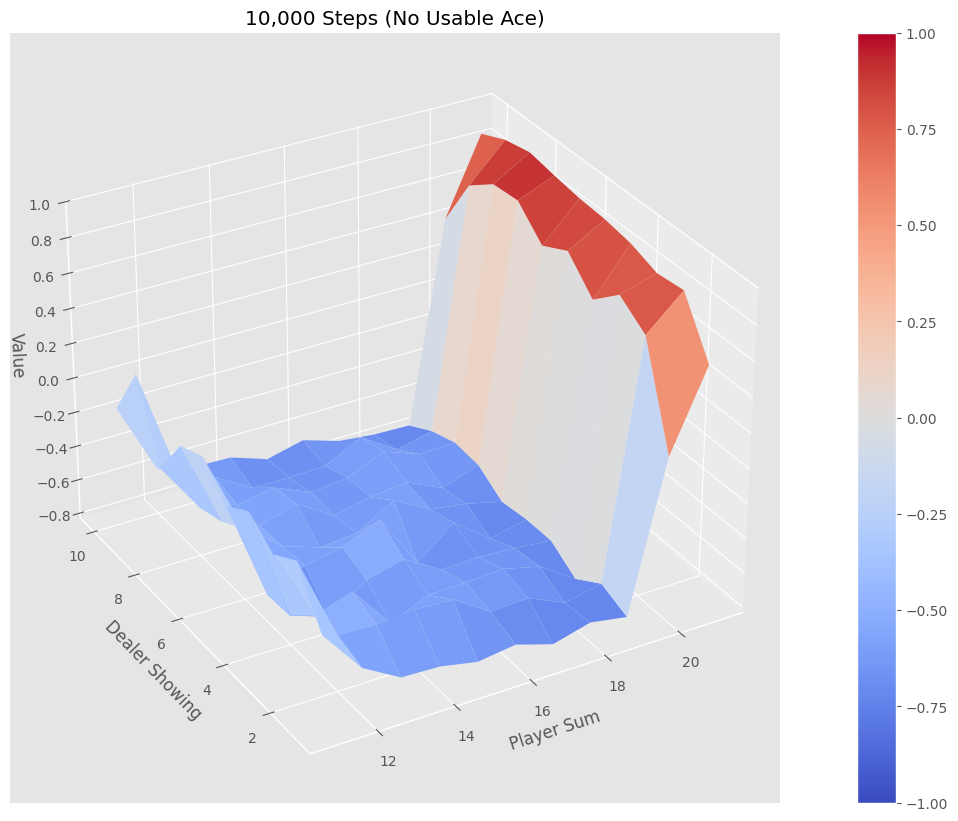

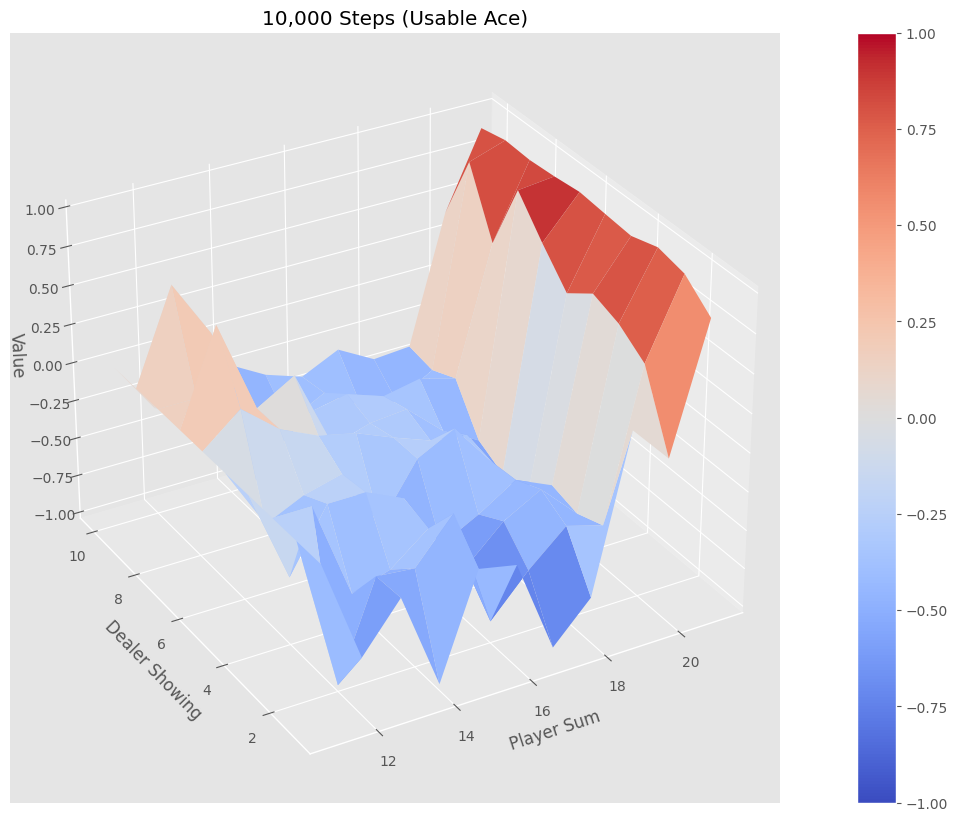

Episode 500000/500000.

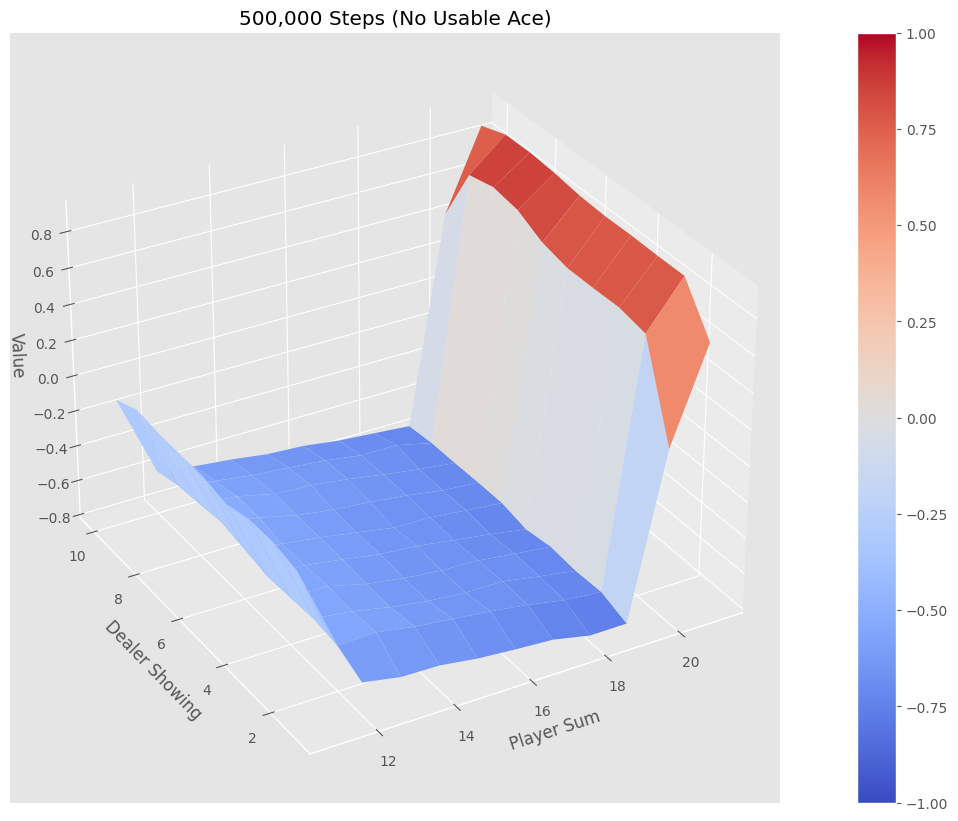

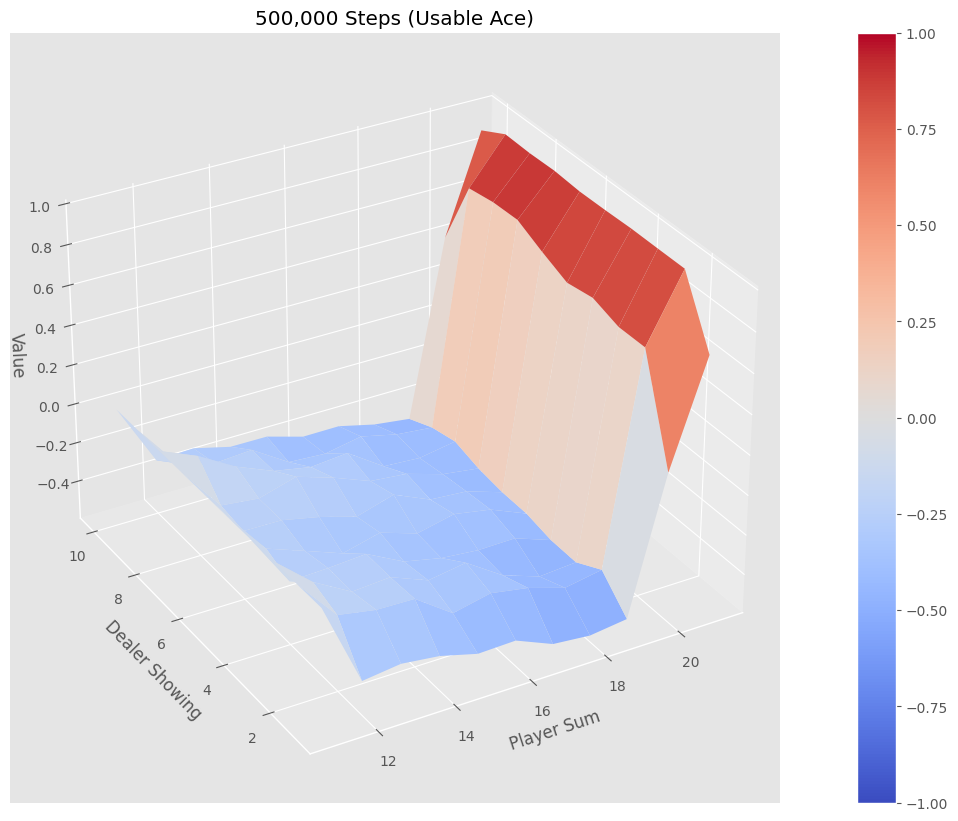

In [22]:
V_10k = mc_predictions(sample_policy, env, num_episodes=10000)
plot_value_function(V_10k, title="10,000 Steps") # Call the function directly

V_500k = mc_predictions(sample_policy, env, num_episodes=500000)
plot_value_function(V_500k, title="500,000 Steps") # Call the function directly
